**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Logistic Regression](#toc1_1_2_)    
      - [Hyper parameter tuning](#toc1_1_2_1_)    
      - [Model Evaluation](#toc1_1_2_2_)    
      - [Model Coefficients](#toc1_1_2_3_)    
      - [Analyzing Model Predictions](#toc1_1_2_4_)    
    - [Random Forest](#toc1_1_3_)    
      - [Hyperparameter tuning](#toc1_1_3_1_)    
      - [Feature Importances](#toc1_1_3_2_)    
    - [Model Evaluation](#toc1_1_4_)    
    - [Comparison to Logistic Regression on Test Data](#toc1_1_5_)    
    - [Conclusion](#toc1_1_6_)    
    - [Naive Bayes Classifier](#toc1_1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we will train two baseline models on our preprocessed data to predict product popularity.
 - Logistic Regression  
 - Random Forest
 
 We will evaluate and compare the performance of these models using different metrics and analyze which metrics are most relevant for different stakeholders. Additionally, we will:

- Analyze key drivers of model performance by examining feature coefficients (for Logistic Regression) and feature importances (for Random Forest).
- Perform error analysis to understand misclassifications and identify patterns in incorrect predictions.

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import string
import spacy

In [2]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
sns.set_style("white")                   #Setting grid style in seaborn

#ignore harmless warnings
from warnings import filterwarnings
filterwarnings(action='ignore')

#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [3]:
# Here we load the preprocessed DataFrame that contains the necessary columns for modeling
meta_df = pd.read_pickle('../data/meta_sample_preprocessed.pkl')
meta_df.head()

,product_title,average_rating,rating_number,product_price,store,parent_asin,all_subcategories,date_first_available,bayesian_rating,is_popular,...,subcategory1_rating_mean,subcategory1_rating_std,combined_category_rating_mean,combined_category_product_counts,combined_category_rating_std,log_combined_category_product_counts,subcategory1_rating_cv,combined_category_rating_cv,subcategory1_target_encoded,combined_category_target_encoded
0,Sterling Silver Hammered Ear Cuff,4.4,243,24.00,twisted designs jewelry,B0178HXZUY,Jewelry Earrings Ear Cuff,2015-10-27,4.407956,0,...,4.442259,0.155776,4.451759,2899,0.151968,7.972466,0.035067,0.034137,0.410765,0.433598
1,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,12.95,yellowbird art & design,B07ZFJXDH8,Home & Kitchen Artwork Prints,2019-11-05,4.496569,0,...,4.495776,0.138751,4.488320,7350,0.140358,8.902592,0.030863,0.031272,0.553306,0.523537
2,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,31.00,black lantern,B089LRPX7X,Home & Kitchen Dining Tableware Glassware Tumb...,2016-01-26,4.457846,0,...,4.495776,0.138751,4.518841,1839,0.128856,7.517521,0.030863,0.028515,0.553306,0.613921
3,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,3.99,generic,B01MXKS1L5,Electronics Accessories Laptop Skins & Decals,2016-11-14,4.442769,0,...,4.471043,0.141498,4.508194,206,0.139531,5.332719,0.031648,0.030951,0.481562,0.592233
4,"Bachelorette Party Shirts, Soft Crew Neck and ...",4.6,64,15.59,patyz,B07Q5VXBCC,Clothing Shoes & Accessories Men Tops Tees T-S...,2019-03-30,4.566003,1,...,4.490060,0.131767,4.479571,1147,0.122598,7.045777,0.029346,0.027368,0.524289,0.471665


In [4]:
#Drop columns that are not required
model_df = meta_df.drop(columns=['rating_number','average_rating','bayesian_rating','product_title','store_product_counts',
                                 'date_first_available','store','all_subcategories','combined_category','title_category',
                                 'product_price','combined_category_product_counts']).copy()

In [5]:
#Set parent_asin column as the index of dataframe
model_df.set_index('parent_asin', inplace=True)

In [6]:
model_df.columns

Index(['is_popular', 'num_product_images', 'product_features',
       'product_title_length', 'is_generic_store', 'log_store_product_counts',
       'store_rating_mean', 'store_rating_std', 'store_rating_cv',
       'store_size_tier', 'store_target_encoded', 'product_age_days',
       'is_weekend_release', 'log_price', 'subcategory1_rating_mean',
       'subcategory1_rating_std', 'combined_category_rating_mean',
       'combined_category_rating_std', 'log_combined_category_product_counts',
       'subcategory1_rating_cv', 'combined_category_rating_cv',
       'subcategory1_target_encoded', 'combined_category_target_encoded'],
      dtype='object')

In [7]:
#check if there are any missing values
model_df.isna().sum().loc[lambda x: x> 0]

Series([], dtype: int64)

### <a id='toc1_1_2_'></a>[Logistic Regression](#toc0_)

In this section, we will train a logistic regression model using a pipeline. Our pipeline will consist of:

- TfIDF Vectorizer for product features 
- One Hot encoder for store_size column/is_generic columns
- Standard Scaler for numerical columns
- Logistic Regression Classifier

Additionally, we perform hyperparameter tuning to find the optimal regularization strength (C) for the classifier.

In [8]:
#lets prepare data for modeling

#Define features
X = model_df.drop(columns=['is_popular'])

#define target
y=model_df['is_popular']


In [9]:
#lets split the data into train and test before applying transformations

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, stratify = y_remainder,random_state = 2)

print(X.shape)

(38154, 22)


In [10]:
#Define custom tokenizer for TF-IDF Vectorization of text data

import unicodedata

# Load the large English pipeline
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])  # Disabling parser & NER for efficiency

def normalize_text(text):
    """
    Normalizes text by converting special Unicode characters into standard ASCII.
    """
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text

def custom_tokenizer(row):
    """
    Tokenizes and lemmatizes a product title, normalizing Unicode characters
    and removing stopwords.

    Args:
        row (str): A product title or description.

    Returns:
        str: Processed text with lemmatized words.
    """
    # Normalize Unicode styles
    normalized_text = normalize_text(row)

    # Process text with spacy
    parsed_title = nlp(normalized_text)

    # Extract only relevant tokens
    tok_lemmas = [
        token.lemma_.lower()    # Convert lemma to lowercase
        for token in parsed_title 
        if token.is_alpha       # Ensure token is alphabetic
        and not token.is_stop   # Remove stopwords
        and len(token) > 3      # Ignore very short words
        and token.pos_ in ("ADJ", "NOUN", "PROPN")  # Extract nouns and adjectives
    ]

    # Remove duplicates while preserving order
    unique_tokens = list(dict.fromkeys(tok_lemmas))

    return unique_tokens  # Convert list to a single string

In [11]:
#Build a pipeline to systematically apply all the transformations to the training data

# 1. Text Processing Pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=custom_tokenizer,  # Custom tokenizer to preprocess text
        lowercase=True,              # Convert all text to lowercase
        min_df=5,                    # Ignore terms that appear in fewer than 5 documents
        max_df=0.30,                 # Ignore terms that appear in more than 30% of documents
        stop_words='english'          # Remove common English stopwords
    )),
    ('feature_select', SelectKBest(chi2, k=500))  # Select top 500 features using Chi-square test
])

# 2. Identifying Numerical Columns (excluding categorical/text columns)
numerical_cols = X.drop(columns=['product_features', 'is_generic_store', 'store_size_tier', 'is_weekend_release']).columns

# 3. Full Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'product_features'),  # Process text column with the text pipeline
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['store_size_tier']),  # OHE for store size tier
    ('passthrough', 'passthrough', ['is_weekend_release','is_generic_store']),  # Keep columns as-is
    ('num', StandardScaler(), numerical_cols)  # Standardize numerical columns
])

# 4. Final Model Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessor
    ('classifier', LogisticRegression(max_iter=5000))  # Logistic Regression model
])

# 5. Fit Model & Evaluate Performance
pipeline.fit(X_train, y_train)
print(f"Train Accuracy: {pipeline.score(X_train, y_train):.4f}")
print(f"Val Accuracy: {pipeline.score(X_val, y_val):.4f}")

Train Accuracy: 0.6911
Val Accuracy: 0.6702


#### <a id='toc1_1_2_1_'></a>[Hyper parameter tuning](#toc0_)

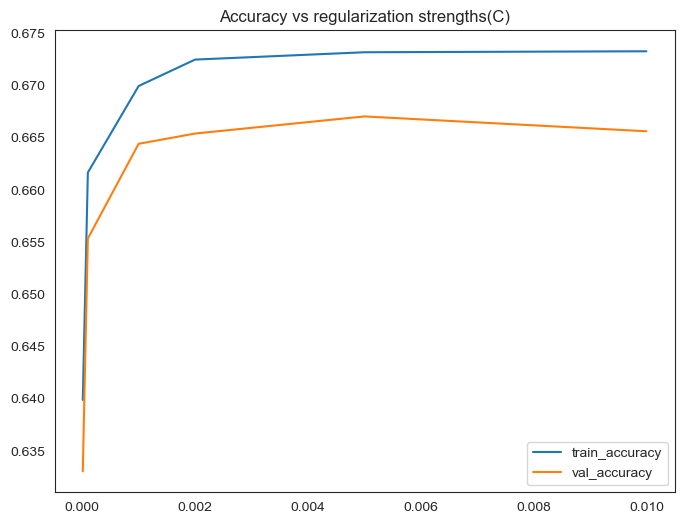

In [12]:
# Tune regularization in Logistic Regression 

train_accuracy = []
val_accuracy = []
param_range = [1e-5, 1e-4, 0.001, 0.002, 0.005, 0.01]

#Instantiate pipeline
pipe_loop = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', LogisticRegression(max_iter=5000)) 
])


for C_param in param_range:
        
    #Update parameter hyper-parameter for every iteration
    pipe_loop.set_params(classifier__C = C_param)    

    #Fit data
    pipe_loop.fit(X_train, y_train)

    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Accuracy vs regularization strengths(C)')
plt.legend()
plt.show()

We observe highest validation accuracy and minimal overfitting with C = 1e-3.

In [13]:
#Refitting Logreg with C=1e-3

pipe_logreg_final  = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', LogisticRegression(C=1e-3, max_iter=5000)) 
])

#Fit Pipeline
pipe_logreg_final.fit(X_train,y_train)
avg_cv_score = np.mean(cross_val_score(pipe_logreg_final, X_train,y_train,cv=5))


#Score
print(f' Train Accuracy of final model: {np.round(pipe_logreg_final.score(X_train,y_train),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_logreg_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.6699
 Test Accuracy of final model: 0.6677


In [ ]:
# Save the model
joblib.dump(pipe_logreg_final, '../models/logreg_metadata_model.pkl')

['../data/logreg_metadata_model.pkl']

#### <a id='toc1_1_2_2_'></a>[Model Evaluation](#toc0_)

Before deep-diving into model evaluation, let’s define the key metrics that matter most for different stakeholders:

**For Customers**: The focus should be on maximizing *Precision* for the “Popular” class (TP / (TP + FP)) to minimize false positives. Misclassifying a product as “popular” when it isn’t could reduce trust in the platform. A high precision ensures that recommended products are genuinely high-quality, improving the overall shopping experience.

**For Sellers**: Sellers benefit from maximizing *Recall* for the “Popular” class (TP / (TP + FN)), or reducing false negatives, ensuring that truly popular products are correctly identified. This prevents situations that could unfairly impact their store reputation and lead to loss of visibility and sales.

**For E-Commerce Platforms**: Platforms should focus on maximizing *Top-5% Precision* for the “Unpopular” class (TP_top5 / (TP_top5 + FP_top5)). This helps detect low-quality or fraudulent listings with high confidence while minimizing wasted audit efforts.

Confusion matrices: 



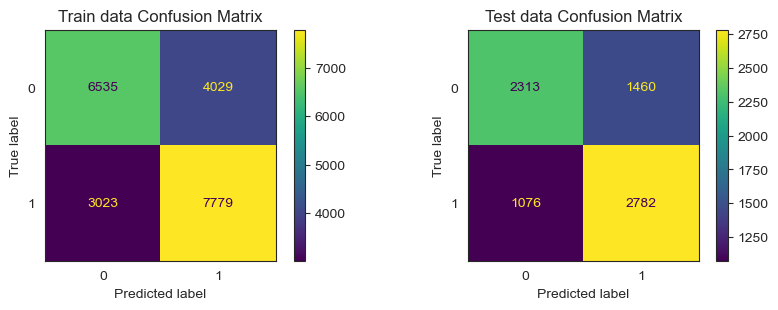


Train data classification report: 
               precision    recall  f1-score   support

           0       0.68      0.62      0.65     10564
           1       0.66      0.72      0.69     10802

    accuracy                           0.67     21366
   macro avg       0.67      0.67      0.67     21366
weighted avg       0.67      0.67      0.67     21366


Test data classification report: 
               precision    recall  f1-score   support

           0       0.68      0.61      0.65      3773
           1       0.66      0.72      0.69      3858

    accuracy                           0.67      7631
   macro avg       0.67      0.67      0.67      7631
weighted avg       0.67      0.67      0.67      7631



In [14]:
#Make predictions
y_pred_train = pipe_logreg_final.predict(X_train)
y_pred_test = pipe_logreg_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# also saving the confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

**Overall Performance**

- The model achieves 67% accuracy on both the train and test sets, suggesting stable generalization.

- Precision and recall scores for both classes are well-balanced, with an F1-score of 0.69 for the Popular class and 0.65 for the Unpopular class.

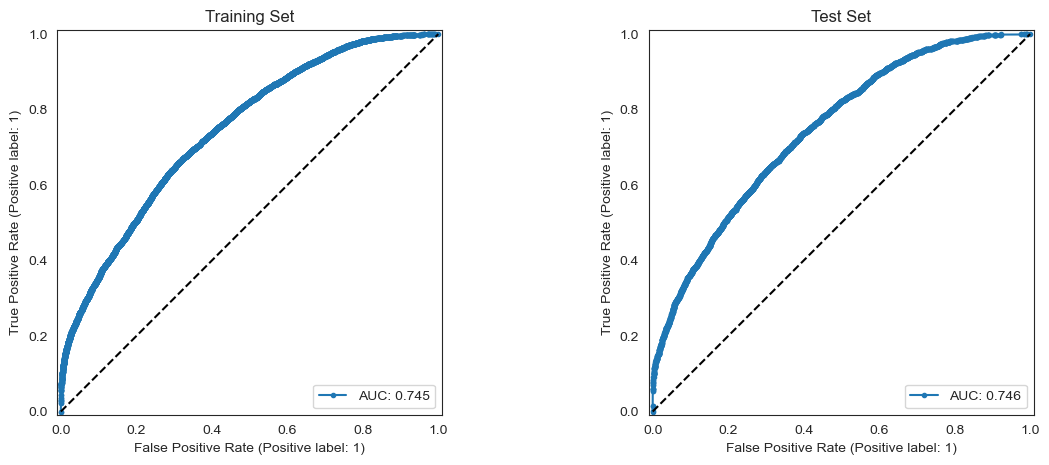

In [15]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_logreg_final.predict_proba(X_train)[:, 1]
y_proba_test = pipe_logreg_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

**ROC-AUC Score**: A ROC-AUC score of 0.74 indicates that there is a 74% chance that the model ranks a randomly chosen popular product higher than a randomly chosen unpopular product. While this indicates moderate discriminatory power, it suggests room for improvement in distinguishing between the two classes.

**Training vs.Test ROC-AUC**: No discrepancy in the ROC-AUC scores between the training and validation datasets suggests that the model is able to generalize well to unseen data.

Below, we break down the model implications for key stakeholders and discuss potential adjustments to improve outcomes.

**Impact on Stakeholders**

**For Customers**: With precision at 66% for the Popular class, there is room for improvement. The model is fairly selective in what it considers “popular,” some misclassified products could still reduce customer trust in recommendations.

**For Sellers**: The recall for Popular is 72%, meaning about 28% of truly popular products are being misclassified as unpopular. This could hurt sellers who rely on product visibility.

**For Platforms**: Since precision for the Unpopular class is 68%, there is some uncertainty in identifying truly low-quality or fraudulent listings. However, it is important to specifically assess its performance on the top 5% least popular products to ensure that audit resources are directed toward the most confidently identified low-quality listings.

**Best Use Case & Potential Threshold Optimization**

Given the current performance, the model is best suited for applications where a balance between precision and recall is required, such as helping customers discover popular products while ensuring sellers get fair exposure. However, depending on the primary stakeholder, the decision threshold could be adjusted:

- For customer-focused applications, increasing the threshold for the Popular class (e.g., requiring a higher probability to classify as popular) could improve precision and reduce false positives.

- For seller-focused applications, lowering the threshold for the Popular class could improve recall, ensuring more truly popular products are identified.

- For platform fraud detection, a separate precision-focused thresholding strategy on the lowest-rated products could help identify poor-quality or fraudulent listings more reliably.

#### <a id='toc1_1_2_3_'></a>[Model Coefficients](#toc0_)

In this section, we analyze which features are considered most important by the model in predicting whether an item is popular or not.

In [16]:
# Put the variable names and their coefficient values into a data frame

#Get feature names from the ColumnTransformer
feature_names = pipe_logreg_final.named_steps['preprocessor'].get_feature_names_out()
#feature_names = X_train.columns

#Extract coefficients from the logistic regression model
coefficients = pipe_logreg_final.named_steps['classifier'].coef_[0]  

# Create the DataFrame to map feature names to coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

#Sort by absolute value of coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True, ignore_index=True)

coef_df_top20 = coef_df.head(20)  #display top 20 coefficients
coef_df_top20                    

,Feature,Coefficient,Abs_Coefficient
0,num__store_target_encoded,0.638684,0.638684
1,num__store_rating_mean,0.263861,0.263861
2,num__combined_category_target_encoded,0.100561,0.100561
3,num__log_price,0.088294,0.088294
4,num__combined_category_rating_mean,0.077739,0.077739
5,num__product_title_length,-0.039132,0.039132
6,num__log_combined_category_product_counts,0.034246,0.034246
7,ohe__store_size_tier_small,0.033905,0.033905
8,ohe__store_size_tier_medium,-0.026798,0.026798
9,num__subcategory1_target_encoded,0.023984,0.023984


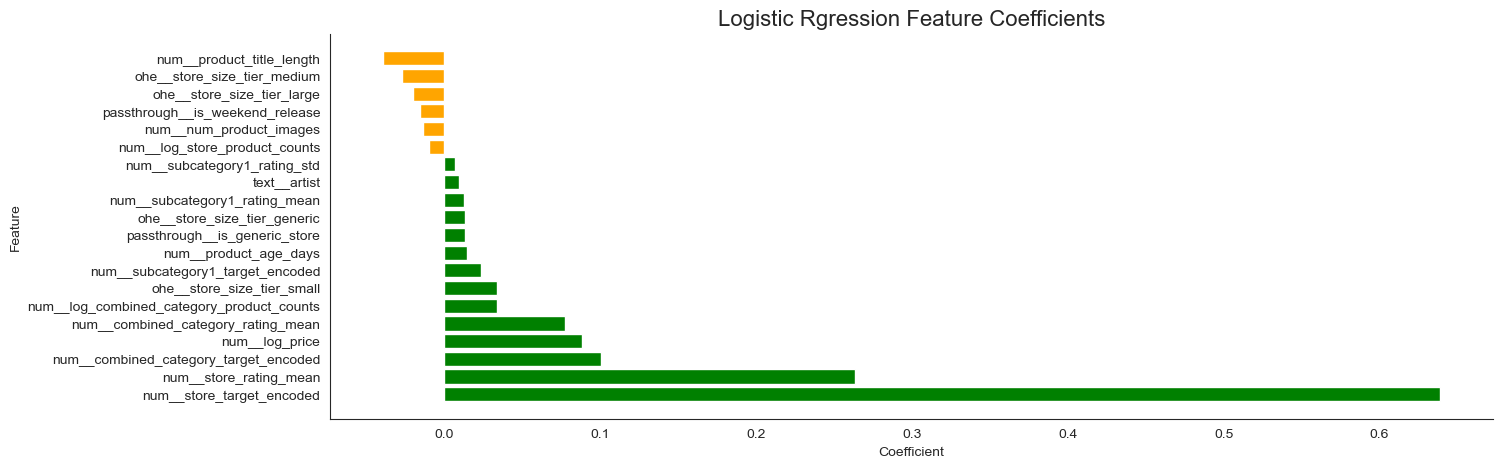

In [17]:
# Plotting Coefficients 
plt.figure(figsize=(15,5))

positive_coefs = coef_df_top20[coef_df_top20['Coefficient'] >=0]
negative_coefs = coef_df_top20[coef_df_top20['Coefficient'] < 0]

# Sort positive and negative coefficients in descending order
positive_coefs = positive_coefs.sort_values(by='Coefficient', ascending=False)
negative_coefs = negative_coefs.sort_values(by='Coefficient', ascending=False) 

plt.barh(positive_coefs['Feature'], positive_coefs['Coefficient'],color='green')
plt.barh(negative_coefs['Feature'], negative_coefs['Coefficient'],color='orange')

plt.title('Logistic Rgression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()

**Key Insights**

- The model primarily relies on numerical features, with store popularity (target encoded) emerging as the most influential factor in predicting product popularity. This is followed by the store’s mean rating, which reflects customer perception, and category-level target encoding, which captures broader demand trends.

- It is important to note that using the target-encoded store column (`num__store_target_encoded`) does not introduce data leakage because it is derived only from historical data available before the prediction point. This feature reflects long-term store performance trends, making it a valid predictive variable rather than an artificially injected signal.

- Other features considered important by the model are product price, product title length, keywords such as artist in product features. 

#### <a id='toc1_1_2_4_'></a>[Analyzing Model Predictions](#toc0_)

In this section, we will analyze the model predictions and gather some insights into the possible reasons for the model's low performance.

In [18]:
#First set parent_asin column as the index of dataframe
meta_df.set_index('parent_asin').head()

,product_title,average_rating,rating_number,product_price,store,all_subcategories,date_first_available,bayesian_rating,is_popular,num_product_images,...,subcategory1_rating_mean,subcategory1_rating_std,combined_category_rating_mean,combined_category_product_counts,combined_category_rating_std,log_combined_category_product_counts,subcategory1_rating_cv,combined_category_rating_cv,subcategory1_target_encoded,combined_category_target_encoded
parent_asin,,,,,,,,,,,,,,,,,,,,,
B0178HXZUY,Sterling Silver Hammered Ear Cuff,4.4,243,24.00,twisted designs jewelry,Jewelry Earrings Ear Cuff,2015-10-27,4.407956,0,3,...,4.442259,0.155776,4.451759,2899,0.151968,7.972466,0.035067,0.034137,0.410765,0.433598
B07ZFJXDH8,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,12.95,yellowbird art & design,Home & Kitchen Artwork Prints,2019-11-05,4.496569,0,8,...,4.495776,0.138751,4.488320,7350,0.140358,8.902592,0.030863,0.031272,0.553306,0.523537
B089LRPX7X,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,31.00,black lantern,Home & Kitchen Dining Tableware Glassware Tumb...,2016-01-26,4.457846,0,8,...,4.495776,0.138751,4.518841,1839,0.128856,7.517521,0.030863,0.028515,0.553306,0.613921
B01MXKS1L5,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,3.99,generic,Electronics Accessories Laptop Skins & Decals,2016-11-14,4.442769,0,2,...,4.471043,0.141498,4.508194,206,0.139531,5.332719,0.031648,0.030951,0.481562,0.592233
B07Q5VXBCC,"Bachelorette Party Shirts, Soft Crew Neck and ...",4.6,64,15.59,patyz,Clothing Shoes & Accessories Men Tops Tees T-S...,2019-03-30,4.566003,1,8,...,4.490060,0.131767,4.479571,1147,0.122598,7.045777,0.029346,0.027368,0.524289,0.471665


In [19]:
# Lets identify incorrect samples
incorrect_pred = (y_train != y_pred_train)

#create a dataframe for y_train 
y_train_incorrect = pd.DataFrame(y_train[incorrect_pred]).rename(columns={'is_popular':'actual'})

#create a dataframe for y_pred_train
y_train_pred_incorrect = pd.DataFrame(y_pred_train[incorrect_pred],columns=['predicted']).set_index(y_train_incorrect.index)

# Combine X_train and y_train for incorrectly predicted samples
incorrect_samples = pd.concat(
    [X_train[incorrect_pred],
     y_train_incorrect, 
     y_train_pred_incorrect],
     axis=1
)

#add store column 
incorrect_samples = incorrect_samples.merge(
    meta_df.set_index('parent_asin')[['store']],      
    left_index=True,     
    right_index=True,       
    how='left'              
)
incorrect_samples.head()

,num_product_images,product_features,product_title_length,is_generic_store,log_store_product_counts,store_rating_mean,store_rating_std,store_rating_cv,store_size_tier,store_target_encoded,...,combined_category_rating_mean,combined_category_rating_std,log_combined_category_product_counts,subcategory1_rating_cv,combined_category_rating_cv,subcategory1_target_encoded,combined_category_target_encoded,actual,predicted,store
parent_asin,,,,,,,,,,,,,,,,,,,,,
B095PVWQ89,1,Plain Burlap Wreath Already Made - Everyday Wr...,107,0,4.595120,4.538874,0.107710,0.023731,medium,0.724490,...,4.498132,0.137408,8.700681,0.030863,0.030548,0.553306,0.571595,0,1,pink door wreaths
B0BZQPRC4W,8,Pumpkin Art Glass Chocolate Halloween Handmade...,125,0,1.791759,4.514040,0.022211,0.004920,small,0.800000,...,4.498132,0.137408,8.700681,0.030863,0.030548,0.553306,0.571595,0,1,hulet glass
B0786B5KYH,9,"Vegetable Garden Marker, Set of 3 Ceramic Vegg...",55,1,9.334680,4.481819,0.133510,0.029789,generic,0.523271,...,4.495621,0.146634,5.746203,0.030863,0.032617,0.553306,0.573718,0,1,generic
B07DCM43QS,9,Cactus and Humans Art Prints - Great Plant Wal...,184,0,6.006353,4.508368,0.139464,0.030935,large,0.538272,...,4.488320,0.140358,8.902592,0.030863,0.031272,0.553306,0.523537,0,1,lone star art
B07RWSNHF2,9,"""The Five W's Of Life""- 8 x 10"" Inspirational ...",199,0,5.948035,4.416386,0.177711,0.040239,large,0.314136,...,4.488320,0.140358,8.902592,0.030863,0.031272,0.553306,0.523537,1,0,american luxury gifts


In [20]:
#Now lets look subset the data where the model got the predictions right.
correct_pred = (y_train == y_pred_train)

diff = meta_df['store'].nunique() - incorrect_samples['store'].nunique()

print(f'Out of {meta_df["store"].nunique()}, there are {diff} stores for which the model got all the predictions right.')


Out of 3455, there are 2241 stores for which the model got all the predictions right.


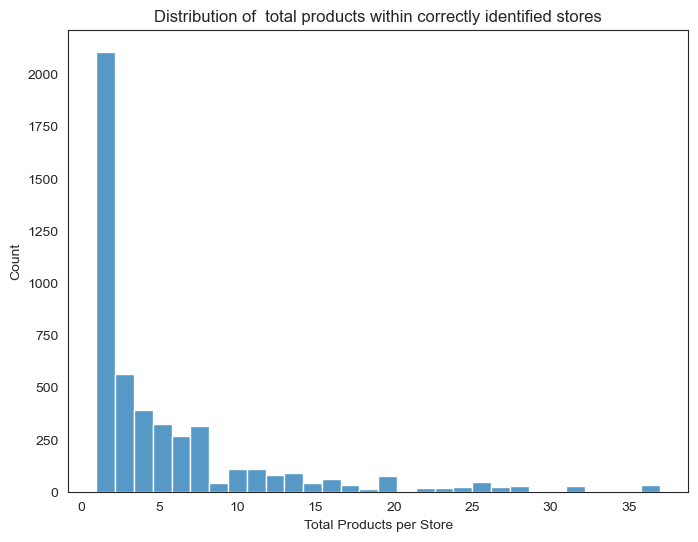

In [21]:
#Distribution of products in corectly identified stores

storenames_incorrect = set(incorrect_samples['store'])
storenames_all= set(meta_df['store'])

correctly_identified_stores = list(storenames_all.difference(storenames_incorrect))
#correct_pred = (y_train == y_pred_train)

sns.histplot(data = meta_df.loc[meta_df['store'].isin(correctly_identified_stores)], x = 'store_product_counts',bins=30)
plt.ylabel('Count')
plt.xlabel('Total Products per Store')
plt.title('Distribution of  total products within correctly identified stores')
plt.show()

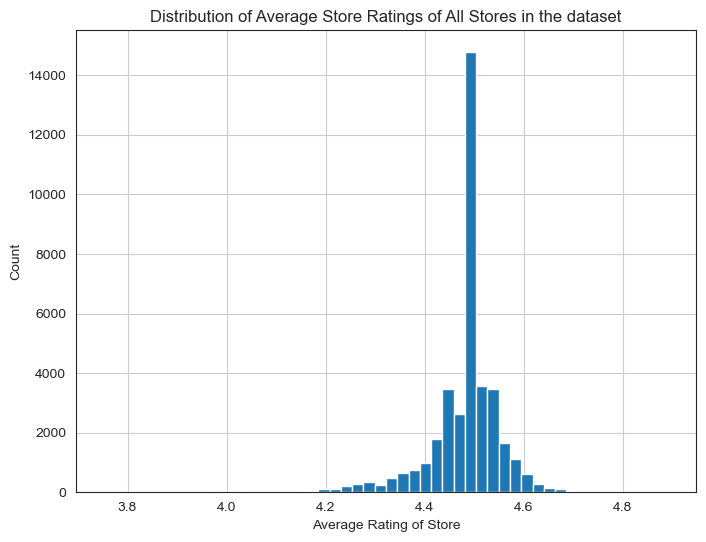

In [22]:
meta_df['store_rating_mean'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Average Rating of Store')
plt.title('Distribution of Average Store Ratings of All Stores in the dataset')
plt.show()

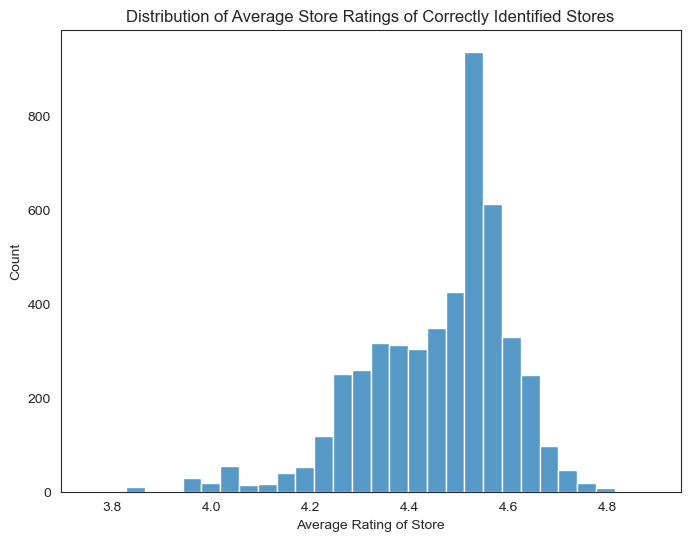

In [23]:
sns.histplot(data = meta_df.loc[meta_df['store'].isin(correctly_identified_stores)], x = 'store_rating_mean',bins=30)
plt.ylabel('Count')
plt.xlabel('Average Rating of Store')
plt.title('Distribution of Average Store Ratings of Correctly Identified Stores')
plt.show()

In [24]:
#correctly identified stores by the model
(meta_df.loc[meta_df["store"] \
            .isin(correctly_identified_stores),
            ['store','store_product_counts','store_rating_mean']]
            .sort_values(by='store_product_counts',ascending=False).round(2)
)

,store,store_product_counts,store_rating_mean
23868,chicwick candles,37,4.26
5211,chicwick candles,37,4.26
27351,chicwick candles,37,4.26
27646,chicwick candles,37,4.26
22825,chicwick candles,37,4.26
...,...,...,...
30135,kusry,1,4.38
30118,b.jonathan99,1,4.43
15284,auntesign,1,4.34
30083,vancortlandt farms,1,4.50


Lets look at the distribution of ratings within "chicwick candles" store

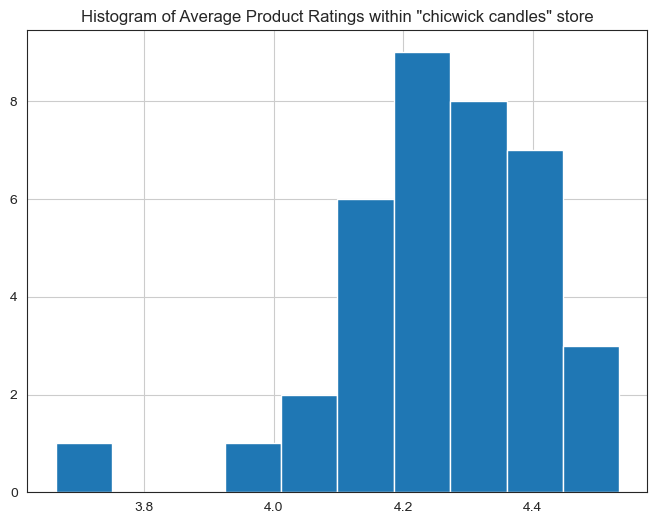

In [25]:
store_df  = meta_df[meta_df['store'] == 'chicwick candles']

store_df['bayesian_rating'].hist()
plt.title('Histogram of Average Product Ratings within "chicwick candles" store')
plt.show()


**Key Insights**
- Model performs well for stores with products < 40.
- For stores with a larger number of products, the model exhibits a higher number of misclassifications.
- The distribution of average ratings of correctly identified stores is slightly right-skewed indicating better performance for stores with higher mean ratings i.e. those with more popular products.
- One potential reason for the model’s lower performance on larger stores is its heavy reliance on store ratings as a proxy for all items, which may not generalize well when product diversity within a store is high.

### <a id='toc1_1_3_'></a>[Random Forest](#toc0_)

In this section, we fit a Random Forest model to the same dataset and asses its performance.

In [26]:
#Build a pipeline to systematically apply all the transformations to the training data

# 1. Text Processing Pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=custom_tokenizer,  # Custom tokenizer to preprocess text
        lowercase=True,              # Convert all text to lowercase
        min_df=5,                    # Ignore terms that appear in fewer than 5 documents
        max_df=0.30,                 # Ignore terms that appear in more than 30% of documents
        stop_words='english'          # Remove common English stopwords
    )),
    ('feature_select', SelectKBest(chi2, k=500))  # Select top 500 features using Chi-square test
])

# 2. Identifying Numerical Columns (excluding categorical/text columns)
numerical_cols = X.drop(columns=['product_features', 'is_generic_store', 'store_size_tier', 'is_weekend_release']).columns

# 3. Full Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'product_features'),  # Process text column with the text pipeline
    ('ohe_store_size', OneHotEncoder(handle_unknown='ignore'), ['store_size_tier']),  # OHE for store size tier
    ('passthrough', 'passthrough', ['is_weekend_release','is_generic_store']),  # Keep columns as-is
    ('num', StandardScaler(), numerical_cols)  # Standardize numerical columns
])

# 4. Final Model Pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessor
    ('classifier', RandomForestClassifier(max_depth=8,n_estimators=100)) 
])

# 5. Fit Model & Evaluate Performance
pipeline_rf.fit(X_train, y_train)
print(f"Train Accuracy: {pipeline_rf.score(X_train, y_train):.4f}")
print(f"Val Accuracy: {pipeline_rf.score(X_val, y_val):.4f}")

Train Accuracy: 0.6838
Val Accuracy: 0.6611


#### <a id='toc1_1_3_1_'></a>[Hyperparameter tuning](#toc0_)

Parameter 1: Max Depth

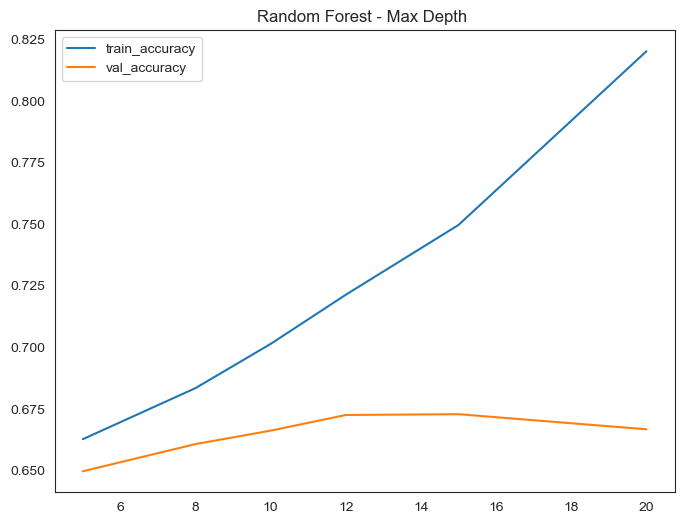

In [27]:
# Run a for loop with different max depths

train_accuracy = []
val_accuracy = []
depth_range = [5,8,10,12,15,20]

#Instantiate pipeline
pipe_loop = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier()) 
])


for depth in depth_range:
    #Update hyper-parameter for every iteration
    pipe_loop.set_params(classifier__max_depth = depth)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(depth_range,train_accuracy,label='train_accuracy')
plt.plot(depth_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - Max Depth ')
plt.legend()
plt.show()

The model begins to overfit beyond max_depth = 8. We now fine-tune other parameters in our model- specifically n_estimaros and min_samples_leaf

Parameter 2: n_estimators or number of decision trees in the model

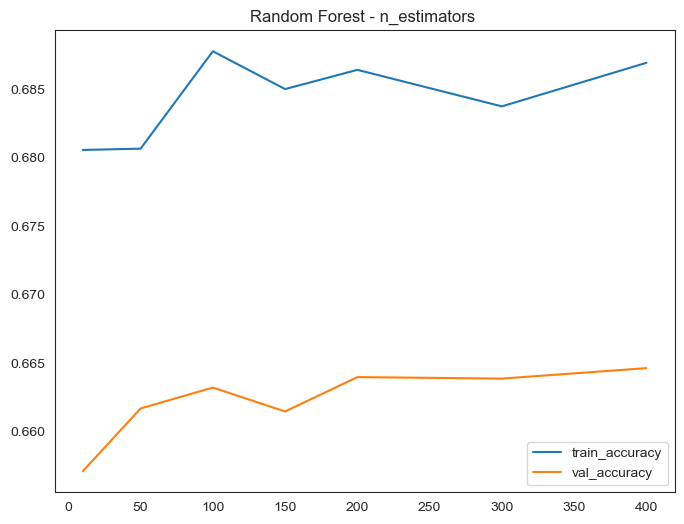

In [28]:
# Run a for loop with different n_estimators

train_accuracy = []
val_accuracy = []
param_range = [10,50,100,150,200,300,400]

#Instantiate pipeline
pipe_loop = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(max_depth=8)) 
])

for param in param_range:
    #Update hyper-parameter for every iteration
    pipe_loop.set_params(classifier__n_estimators = param)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - n_estimators ')
plt.legend()
plt.show()

As we change n_estimators, we don't see any significant differences in the accuracy. We choose n_estimators=50 for our final model.

Parameter 3: min_samples_leaf

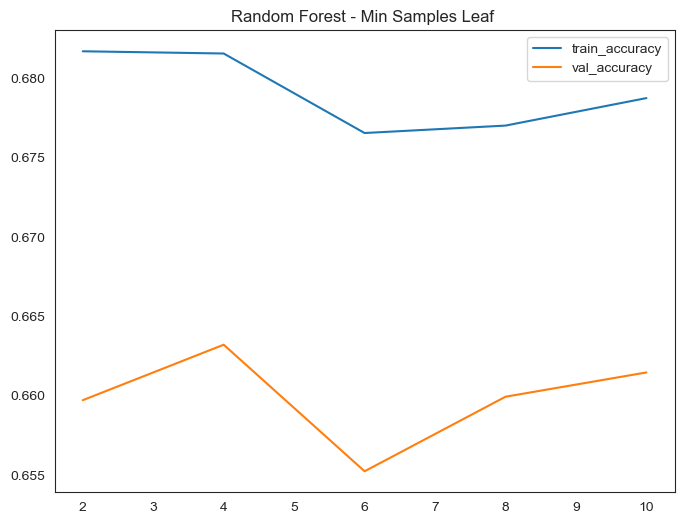

In [31]:
# Run a for loop with different min_samples_leaf

train_accuracy = []
val_accuracy = []
param_range = [2,4,6,8,10]

#Instantiate pipeline
pipe_loop = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(max_depth=8)) 
])


for param in param_range:
    #Update hyper-parameter for every iteration
    pipe_loop.set_params(classifier__min_samples_leaf = param)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - Min Samples Leaf ')
plt.legend()
plt.show()

Again, min_samples_leaf has a minimal impact on the model's performance, We choose min_samples_leaf = 4 in our final model.

In [32]:
#Refitting Random Forest with max_depth = 8, n_estimators = 50, min_samples_leaf = 4

#Instantiate Pipeline
pipe_rf_final = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(max_depth = 10, n_estimators = 50, min_samples_leaf = 4)) 
])

#Fit Pipeline
pipe_rf_final.fit(X_train,y_train)

#Score
print(f' Train Accuracy of final model: {np.round(pipe_rf_final.score(X_train,y_train),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_rf_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.691
 Test Accuracy of final model: 0.6657


#### <a id='toc1_1_3_2_'></a>[Feature Importances](#toc0_)

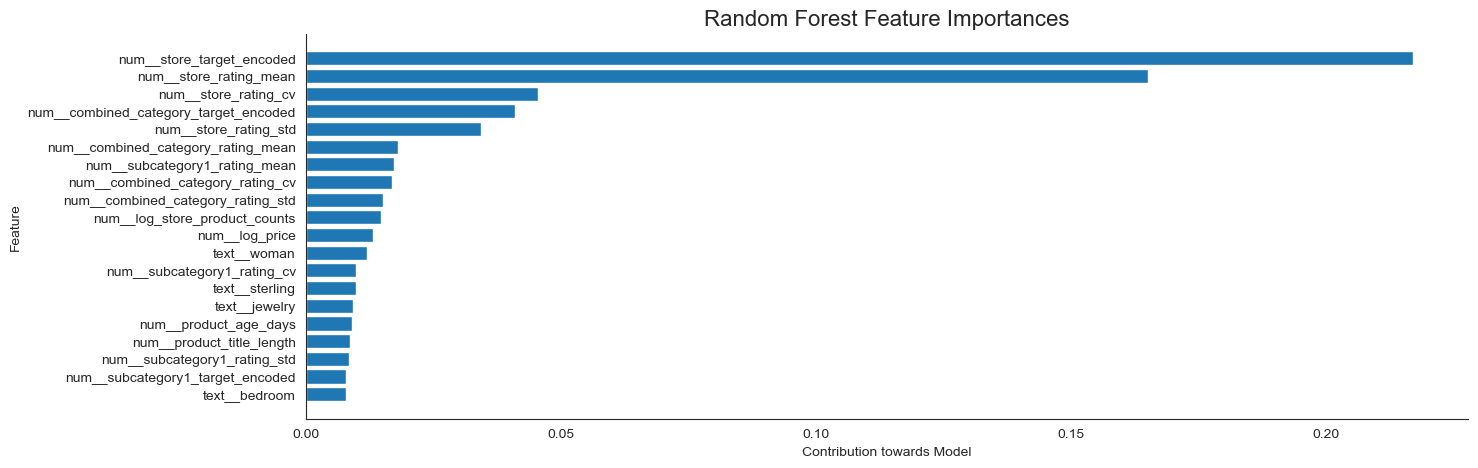

In [34]:
#Get feature names from the ColumnTransformer
feature_names = pipe_rf_final.named_steps['preprocessor'].get_feature_names_out()

#Extract coefficients from the logistic regression model
feature_importances = pipe_rf_final.named_steps['classifier'].feature_importances_  

# Create the DataFrame to map feature names to coefficients
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True) # Sort coefficients in descending order

importance_df_top20 = importance_df.head(20)  
importance_df_top20 = importance_df_top20.sort_values(by = 'Importance')
# Plotting Feature Importances
plt.figure(figsize=(15,5))

plt.barh(importance_df_top20['Feature'], importance_df_top20['Importance'])

plt.title('Random Forest Feature Importances', fontsize=16)
plt.xlabel('Contribution towards Model')
plt.ylabel('Feature')
sns.despine()
plt.show()

Random Forest Model also identifies numerical features in the model as more important than the categorical features

### <a id='toc1_1_4_'></a>[Model Evaluation](#toc0_)

Confusion matrices: 



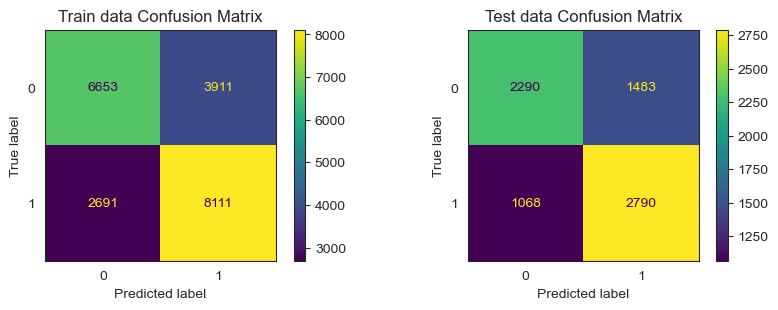


Train data classification report: 
               precision    recall  f1-score   support

           0       0.71      0.63      0.67     10564
           1       0.67      0.75      0.71     10802

    accuracy                           0.69     21366
   macro avg       0.69      0.69      0.69     21366
weighted avg       0.69      0.69      0.69     21366


Test data classification report: 
               precision    recall  f1-score   support

           0       0.68      0.61      0.64      3773
           1       0.65      0.72      0.69      3858

    accuracy                           0.67      7631
   macro avg       0.67      0.67      0.66      7631
weighted avg       0.67      0.67      0.66      7631



In [35]:
#Make predictions
y_pred_train = pipe_rf_final.predict(X_train)
y_pred_test = pipe_rf_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(pipe_rf_final, X_train, y_train, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(pipe_rf_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# also saving the confusion matrix
conmat_rf = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

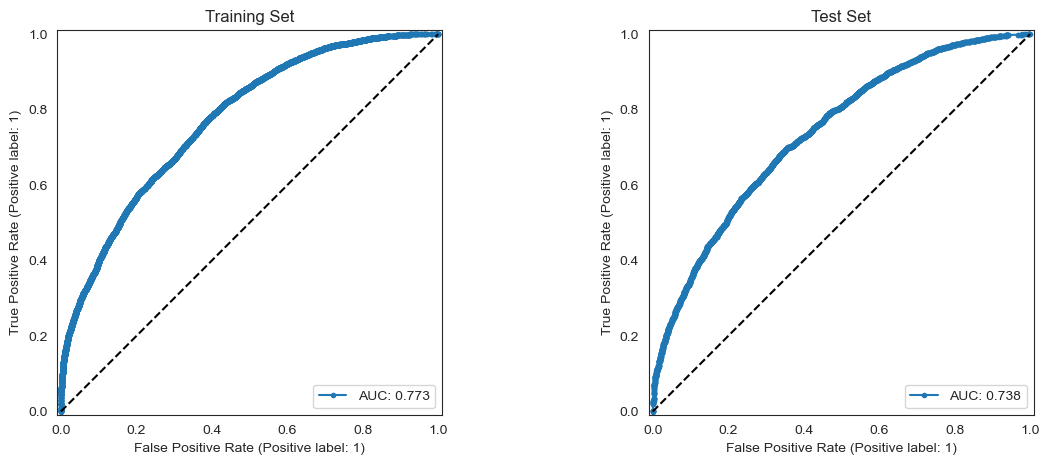

In [36]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_rf_final.predict_proba(X_train)[:, 1]
y_proba_test = pipe_rf_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_rf_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_rf_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

### <a id='toc1_1_5_'></a>[Comparison to Logistic Regression on Test Data](#toc0_)

In [37]:
print('Logistic Regression Test data Performance:')
display(conmat)
print('Random Forest Test data Performance:')
display(conmat_rf)

Logistic Regression Test data Performance:


,predicted 0,predicted 1
true 0,2313,1460
true 1,1076,2782


Random Forest Test data Performance:


,predicted 0,predicted 1
true 0,2290,1483
true 1,1068,2790


Model Summary on Class 1 (popular items) Test data
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**Logistic Regression**|66%|72%|69%|74%
|**Random Forest**|65%|72%|69%|74%

Model Summary on Class 0 (unpopular items) Test data
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**Logistic Regression**|68%|61%|65%|74%
|**Random Forest**|68%|61%|64%|74%

Both, Random Forest and Logistic performed similarly in terms of the different evaluation metrics - precision, recall, f1 score and ROC-AUC, suggesting comparable overall classification ability. 

### <a id='toc1_1_6_'></a>[Conclusion](#toc0_)

Both Logistic Regression and Random Forest exhibit moderate model performance, achieving a similar accuracy of 65% on the test data.

The model heavily relies on a few key features related to store- and category-based rating statistics. Additionally, textual metadata, such as product features, does not demonstrate strong predictive power in determining product popularity.

Overall, the model’s performance aligns with industry benchmarks for metadata-based models (Linden et al., 2017; Wang et al., 2020; Chen et al., 2023).

To enhance performance, the model would benefit from incorporating more diverse and meaningful features. Potential improvements include:
	•	Utilizing neural networks to capture more complex patterns in the data.
	•	Expanding the feature space with additional attributes such as user behavior patterns, brand verification from external sources, and product image analysis using image embeddings.